# Start to Finish Example: BBH Merger From $\psi_4$ Data to MP4 Movie

## Author: Tyndale Stutzman, Seth Winchell

## This tutorial provides an overview of how to take primitive binary black hole merger data ($\psi_4$) and visualize it as an MP4 movie.

## Introduction: 

Among a plethora of data produced by the Black Holes At Home (BH@H) project, $\psi_4$ data is the most valuable for visualization purposes as it contains information regarding gravitational wave strain, $\textit{h}$. The purpose of this notebook is to provide a general example of extracting $\textit{h}$ from $\psi_4$, creating a series of meshes, and finally animating these meshes along with their constituent black holes in a final, downloadable movie that can then be edited in post. As such, this tutorial is not exhaustive, however, links to more detailed notebooks can be found in certain sections. 

<!-- note to anyone reading this... do we need more of a casual introduction here? How much do we talk about it vs diving in? Thanks. -->

### Prerequisites:

This program relies on a number of Python libraries:

<!-- comment to whomever asked about the packages: I think we'd be in a good spot to create a requirements.txt but we'd include it in an installation section. The prerequisite section is referring to reading material-->

### Recommended:

While the following references are not critical to producing a movie given BH@H data, they provide valuable insight into the underlying concepts behind each step in this overview. <!-- redundant? -->

<!-- stupid question but I'm assuming I can't use visit all packaged up in the notebook, right? -->

###### *This notebook is very much in progress

<a id='toc'></a>
# Table of Contents:
$$\label{toc}$$
<!--these buttons aren't functioning properly so maybe figure that out-->
1. [Step 0](installation): Installing Prerequisites
   1. [0.a](windows):
   2. [0.b](osx):
   3. [0.c](linux):
2. [Step 1](#psi4_to_h): Extracting $\textit{h}$ from $\psi_4$
    1. [1.a](#freq_int): Domain expansion: frequency integration <!-- Yes I'll change these names to something more serious-->
    2. [1.b](#filter): Catching our drift: finding $\omega_0$
3. [Step 2](#mesh_gen): Generate gravitational wave mesh
    1. [2.a](#swsh): Finding spin-weighted spherical harmonics
    2. [2.b](#interp): Interpolating strain with spacetime points
4. [Step 3](#sync): Synchronize mesh with black hole trajectories
5. [Step 4](#animate): Animate gravitational waves and black holes
    1. [4.1](#pipeline): Mayavi Pipeline
    2. [4.2](#tvtk): Traited VTK (TVTK) and meshes
    3. [4.3](#movie): Record Frames and Compile MP4
6. [Step 5](#conclusion): Conclusion
7. [Step 6](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='installation'></a>

# Step 0: Installing Prerequisites \[Back to [top](#toc)\]
$$\label{installation}$$



<a id='psi4_to_h'></a>

# Step 1: Extracting $\textit{h}$ from $\psi_4$ \[Back to [top](#toc)\]
$$\label{psi4_to_h}$$

In order to process $\psi_4$ into a form that can be visualized, the gravitational wave strain $\textit{h}$ must first be extracted. $\psi_4$ is one of the five [Weyl Scalars](https://en.wikipedia.org/wiki/Weyl_scalar) that describe the curvature of spacetime affected by gravitational waves, and best corresponds to the transverse wave radiation strain, $\textit{h}$. Strain is comprised of a "plus" and "cross" polarization, where each component stretches spacetime at a 45 degree difference - this is expressed as a complex value, and in the simplest sense can be found through a **double time integration** of $\psi_4$ data. A full gravitational waveform is also a superposition of different $(\textit{l}, \textit{m})$ wave modes, similar in concept to a quantum mechanical wave equation, so a gravitational wave strain can be expressed through its components as:

\begin{equation}
    \textit{h} = \sum_{l=2}^8 \sum_{m=-l}^l \textit{h}_{+}^{lm} - \textit{ih}_{\times}^{lm}
\end{equation}

Unfortunately a direct double integration in the time domain of $\psi_4$ is insufficient in visualizing strain, mainly for two related reasons:

* **Unphysical noise in the wave:** Because current data collection methods for $\psi_4$ are imperfect, they often create and/or pick up spurious signals unrelated to the system.

* **Non-linear drifts in data:** These noise errors will accumulate in a direct double time integration, appearing as a significant drift away from the original oscillation axis of $h$.

To alleviate these issues the data for visualization is instead [**integrated in the frequency domain**](#freq_int) by performing a Fast Fourier Transform (FFT) on the $\psi_4$ data before going through a simple Fixed Frequency Integration (FFI) formula - an inverse FFT is then done on the result to retrieve $h$. The FFI formula only depends on the associated frequency where we integrate the wave, so [**frequency filtering**](#filter) is applied during FFI by calculating and applying a minimum cutoff frequency to exclude the effects of noise in the data. At the same time this technique will get rid of the upward drift mentioned before - two birds with one stone!

Recall that a full gravitational wave strain needs to account for all the $(\textit{l}, \textit{m})$ modes, specifially from $l = 2$ to $l = 8$. This **integration is repeated for all the modes** and reconstructed with [**spin-weighted spherical harmonics (link to section here)**]() later before visualizing.

###### For a more technical summary of these waveform integration techniques, please see [**this paper by Reisswig and Pollney**](https://arxiv.org/abs/1006.1632)


<a id='freq_int'></a>

## Step 1.a: Domain expansion: frequency integration \[Back to [top](#toc)\]
$$\label{freq_int}$$

Fortunately, the `numpy` module has functions that can take a **Fast Fourier Transform (FFT)** and its associated frequencies with ease:

In [ ]:
import numpy as np

# Take the FFT using a list of the complex values of psi4 from our original data
fft_result = np.fft.fft(real_psi4 + 1j * imag_psi4) 

# Find the sample frequencies corresponding to each data point going into the FFT
omega_list = np.fft.fftfreq(len(psi4_times), dt) * 2 * np.pi

But where's the fun in that if we don't know what a Fourier transform is and how it can help with simplifying integration?

A **Fourier transform** will turn a regular time dependent function, say $g(t)$, and express it as a function of frequencies present in $g(t)$. A Fourier transform of a simple waveform can be thought of as breaking a wave into its constituent pure waves and projecting them into the **frequency domain**, where they appear as peaks at their corresponding frequencies. For instance, a Fourier transform of a wave comprised of 3 sine waves then looks like:

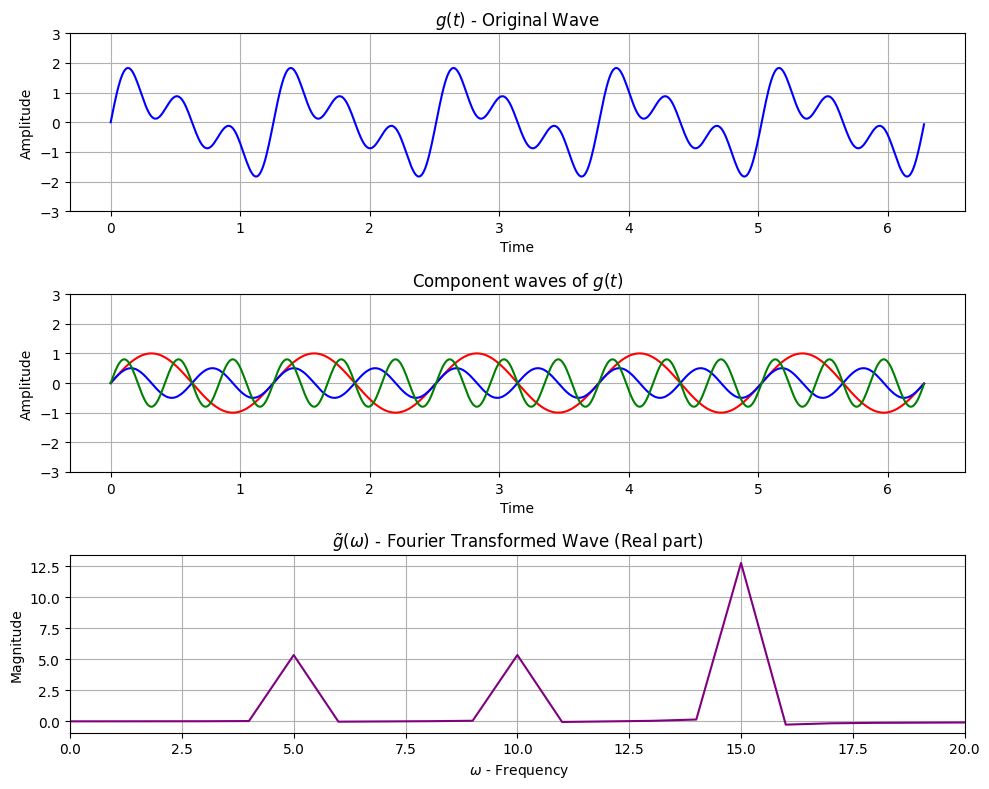

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters for the sine waves
amplitude1 = 1.0
frequency1 = 5.0
amplitude2 = 0.5
frequency2 = 10.0
amplitude3 = 0.8
frequency3 = 15.0

# Generate x values from 0 to 2*pi with a step size of 0.01
x = np.arange(0, 2*np.pi, 0.01)

# Create three sine waves
wave1 = amplitude1 * np.sin(frequency1 * x)
wave2 = amplitude2 * np.sin(frequency2 * x)
wave3 = amplitude3 * np.sin(frequency3 * x)

# Combine the three waves to form the composite wave
composite_wave = wave1 + wave2 + wave3

# Compute the Fourier transform of the composite wave
fourier_transform = np.fft.fft(composite_wave)

# Plot the original wave
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(x, composite_wave, color='blue')
plt.title(r'$g(t)$ - Original Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.ylim(-3, 3)

# Plot the 3 decomposed sine waves
plt.subplot(3, 1, 2)
plt.plot(x, wave1, color="red")
plt.plot(x, wave2, color="blue")
plt.plot(x, wave3, color="green")
plt.title(r'Component waves of $g(t)$')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.ylim(-3, 3)

# Plot the Fourier transformed wave
plt.subplot(3, 1, 3)
plt.plot(fourier_transform.real, color='purple')
plt.title(r'$\~g(\omega)$ - Fourier Transformed Wave (Real part)')
plt.xlabel(r' $\omega$ - Frequency')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim(0, 20)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

Matching the $\omega$ with each peak shows that the Fourier transform "picked out" the frequencies that made up the original wave! But you may have noticed that what was plotted was only the "real" part of the Fourier transform, which suggests that  this operation spits out a complex value. That observation is indeed true, and can be verified by the **mathematical expression of the Fourier transform**:

\begin{equation}
    \~g(\omega) = \int_{-\infty}^{\infty} g(t)e^{-2i\pi\omega t} \, dt
\end{equation}

Analyzing each component of this expression can give us an intuition of what's really going on - the original function $g(t)$ can be found in the integrand, and the exponential factor can recast these **g vs. t** values to **imaginary vs. real** values in the complex plane using Euler's formula: 

\begin{equation}
e^{i\theta} = cos(\theta) + isin(\theta)
\end{equation}

Within this exponential the value $\omega$ is introduced as the independent variable that can "search" for when that value lines up with the frequency of $g(t)$. Look what happens to the integrand for different $\omega$ values on a sine wave with frequency 3 cycles per second:

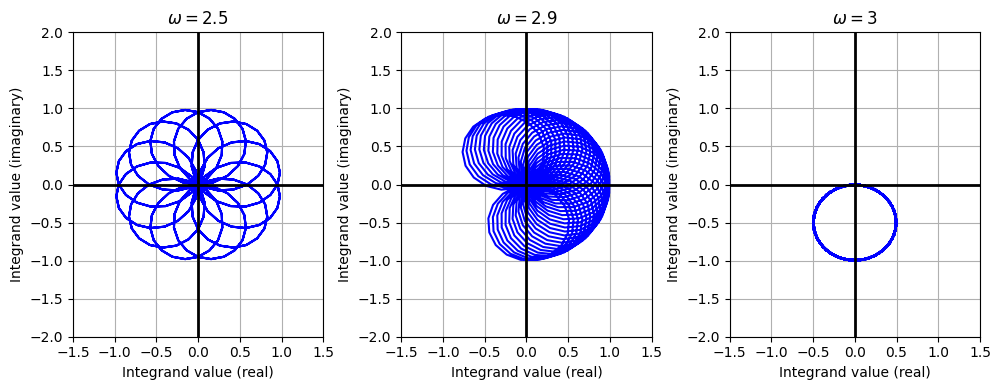

In [127]:
# Generate time coords for original wave
t = np.arange(0, 6, 0.01)

# Initialize g(t): sine wave with frequency of 3 cycles/second
freq_wave = 3 
wave = np.sin(freq_wave * (2*np.pi) * t)

# Declare "searching frequencies" (omega) for each plot
search_freqs = [2.5, 2.9, 3]


plt.figure(figsize=(10, 4))
for i, s in enumerate(search_freqs):
    # Exponential term
    search_factor = np.exp(1j * (-2 * np.pi) * s * t)

    # Integrand term
    result = wave * search_factor

    # Create plots
    plt.subplot(1, 3, i + 1)
    plt.plot(result.real, result.imag, color='blue')
    plt.xlim(-1.5 , 1.5)
    plt.ylim(-2, 2)
    plt.axhline(0, color='black', linewidth=2)
    plt.axvline(0, color='black', linewidth=2)
    plt.title(r'$\omega = $' + f'{s}')
    plt.xlabel("Integrand value (real)")
    plt.ylabel("Integrand value (imaginary)")
    plt.grid(True)

plt.tight_layout()

# Display the plot
plt.show()

When $\omega$ matches the frequency of $g(t)$, the graph in the complex plane collapses and lines itself up! Notice that when this happens the graph's hypothetical **"center of mass"** is shifted significantly away from the origin - and the integral found in the Fourier transform has an analagous effect of finding this "center of mass". The plot of $\^g(\omega)$ farther above represents the real coordinate in these complex plane graphs, so we can just as well plot the imaginary part that will produce similar peaks.

One detail to note is that computers must do this process with discrete data values and cannot take integrals analytically, so the algorithm that `numpy` uses is called the **Fast** Fourier transform [(FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform), which produces the same effect as a regular Fourier transform but by using discrete value approximations and matrix manipulations.

###### See this [3Blue1Brown video](https://www.youtube.com/watch?v=spUNpyF58BY) for good visaul animations of Fourier transforms.

After getting an intuition for the Fourier transform, let's recall the original goal - to find the observable gravitational wave strain, $h(t)$, by taking the 2nd derivative in time of complex valued $\psi_{4}$ data without drifts in our resulting strain, which is caused by noise in $\psi_4$. This is where the **Fixed Frequency Integration** (FFI) technique comes into play, and satisfies all the requirements mentioned. According to [eq. 27 in Reisswig's paper](https://arxiv.org/abs/1006.1632), integrating the Fourier transformed data in the frequency domain is surprisingly simple:

\begin{equation}
\~F(\omega) = \begin{cases}
                -i\~f(\omega)/{\omega_{0}}, \textrm{  if  }\omega \leq \omega_{0} \\
                -i\~f(\omega)/{\omega}, \textrm{  if  }\omega > \omega_{0}
                \end{cases}
\end{equation}

Since $\~F(\omega)$ represents the integral of of the the Fourier transform $\~f(\omega)$, then the double integral can be found just by multiplying the original $\~f(\omega)$ by $(-i/\omega)^2$ or $(-i/\omega_{0})^2$ depending on the value of the **cutoff frequency**, $\omega_{0}$. Thankfully this is easily transalatable into code!

In [ ]:
# Found in the main function of util-psi4_to_phase_amp_omega_FFI_strain_psi4check.py
for i, omega in enumerate(omega_list):
    if np.fabs(omega) <= min_omega:
        fft_result[i] *= 1 / (1j * min_omega) ** 2
    else:
        fft_result[i] *= 1 / (1j * np.fabs(omega)) ** 2

After the second integral is found we can call `np.fft.ifft(integrated_data)` to take the **inverse Fourier transform** and get the strain $h(t)$ in the time domain once again. Mathematically the inverse Fourier transform is the same operation but with $~g(\omega)$ in the integrand, effectively undoing the transform:

\begin{equation}
    g(t) = \int_{-\infty}^{\infty} \~g(\omega) e^{2i\pi\omega t} \, d \omega
\end{equation}

As the name suggests, $\omega_{0}$ is a free parameter that represents lowest frequency that the original waveform is expected to have. When applied to this integration, it will eliminate any component waveform with a frequency lower than $\omega_{0}$, by virtue of the conditional applied. Think of it as removing peaks below a certain $\omega$ value in the original plot of $\~g(\omega)$ above. This effectively removes unphysical drifts in the the amplitude of $h$ when the wave is put back into the time domain.

<a id='filter'></a>

## Step 1.b: Catching our drift: finding $\omega_0$ \[Back to [top](#toc)\]
$$\label{filter}$$

After exploring this clever technique of integrating and filtering in the frequency domain to get a more physically accurate $h(t)$, there is one concern that was glossed over in the previous step: what is $\omega_0$ and how do we find this parameter to use in frequency filtering?

The purpose of these scripts is to make the visualization of binary black hole mergers from raw $\psi_4$ data as automated and seamless as possible, so leaving a free parameter like $\omega_0$ to be inputted by the user is not desireable, especially if they are new to these concepts and are unsure on how to analyze waveforms in such a way as to pick out unphysical frequencies. Unlike other packages like Kuibit that require $\omega_0$ as a user input to perform this type of integration, the integration script in this module will find an acceptable minimum cutoff frequency automatically in a few steps.

Consider a graph of $\psi_4$ data below, showing it's components of real, imaginary and total amplitude $\sqrt(Re(\psi_4)^2 + Im(\psi_4)^2)$ parts. This is from real BlackHoles@Home data, representing the dominant mode $(l, m) = (2, 2)$ of the Binary Black Hole merger GW150914.

![$psi_4$ data](images/psi4_graph.png)

> One important detail before moving on to frequency analysis here: time (horizontal axis) is offset by a constant of $R_{ext}$, which is the particular **radius of extraction** from the center of mass of the binary that the data is taken, which in this case is equal to 100. This offset is reffered to as the **retarded time** in merger analysis. But wait, what's up with the units - why are units of distance subtracted by units of time? The answer comes from how general relativity handles units, with a [**geometrized unit system**](https://en.wikipedia.org/wiki/Geometrized_unit_system) that sets the speed of light and the gravitational constant equal to one $(c = G = 1)$.

Let's tie this graphical representation of $\psi_4$ to a physical intuition. The beginning of this graph corresponds to the beginning of this binary's **inspiral**, when they are the farthest apart and orbiting around each other the slowest. As they move closer, they orbit around each other faster, increasing both the amplitude and frequency of the gravitational waves they generate. The waves peak at the time of the binary's **merger** (around $(t-R_{ext}) = 900$) in the graph above, where their influence on each other is exponentially strong, and quickly dissipates when they form a single black hole during **ringdown**. 

![strain and black holes](https://www.researchgate.net/profile/Philipp-Scharpf/publication/319208978/figure/fig75/AS:810604923195403@1570274682540/indicates-the-position-of-the-merger-part-of-the-Binary-Black-Hole-waveform.ppm)

###### image by Philipp Scharpf on researchgate.net (*would be nice to have our own gif/image like this from our visualizations to put here instead!)

But you may notice in the graph a few blips near the beginning - those are entirely unphysical and are an example of the errors mentioned at the beginning of this section. Since the goal is to find the minimum frequency ($\omega_0$), it would be natural to find it as close to the beginning of this merger as possible, when the black holes' orbits are slowest and consequently their gravitational waves are the longest. 

Plotting trends of **phase $(\phi)$** between the real and imaginary parts of $\psi_4$, as well as **frequency $(\omega)$** against time can give us some insight on how these blips are a large hinderance in finding $\omega_0$. Under a few mathematical operations these plots can be generated:

\begin{equation}
    \phi(t) = \arctan\frac{Re(\psi_4)}{Im(\psi_4)}
\end{equation}

\begin{equation}
    \frac{d\phi_c}{dt} = \omega(t) 
\end{equation}

![cumulative phase, omega, and quadratic fit](images/psi4_freq_analysis_no_quad.png)

> Specifically, the **instantaneous phase** $(\phi(t))$ is related to the "misalignment" between real and imaginary parts of $\psi_4$ (hence the $arctan$ term), and $\omega$ is found by the time derivative of the **cumulative phase**, $(\phi_c(t))$

It should now be more apparent that the frequencies at the physical beginning of the binary's inspiral ($t_{ret} = 0$) are too noisy to directly pull from as $\omega_0$. But with a bit of extrapolation, this visualization script fits a quadratic curve around the times closest to the beginning without including the noisy data (from $t_{ret} = R_{ext}$ to $t_{ret} = R_{ext} + 200$) and evaluates $\omega_0$ through that quadratic at $t_{ret} = t-R_{ext} = 0$. Here's a code snippet of the function that does this:

In [ ]:
# code snippet from integration script - not intended to work in this notebook

def fit_quadratic_to_omega_and_find_minimum(
    r_over_M: float, time: NDArray[np.float64], omega: NDArray[np.float64]
) -> float:
    """
    Fits a quadratic curve to the filtered omega data within a specified time range and outputs the minimum omega value.

    :param r_over_M: the radius from the center of the binary where the psi4 data is extracted from.
    :param time: A numpy array containing time values.
    :param omega: A numpy array containing omega values corresponding to the time values.

    :return: The absolute value of the quadratic curve evaluated at t=0.

    :raises ValueError: If the lengths of time and omega arrays are not equal.
    """
    if len(time) != len(omega):
        raise ValueError("The lengths of time and omega arrays must be equal.")

    def quadratic(x: float, a: float, b: float, c: float) -> float:
        """
        Represents a quadratic function.

        :param x: The independent variable.
        :param a: The coefficient of the x^2 term.
        :param b: The coefficient of the x term.
        :param c: The constant term.

        :return: The value of the quadratic function at x.
        """
        return a * x**2 + b * x + c

    # Filter the data for t=r_over_M to t=r_over_M+200
    fit_start = r_over_M
    fit_end = r_over_M + 200.0
    time_filtered = time[(time >= fit_start) & (time <= fit_end)]
    omega_filtered = omega[(time >= fit_start) & (time <= fit_end)]

    # Fit a quadratic curve to the Omega data using nonlinear least squares
    params, _ = curve_fit(quadratic, time_filtered, omega_filtered)

    # Find the extremum value of the quadratic curve
    a, b, c = params
    extremum_x = -b / (2 * a)
    omega_min_quad_fit = np.fabs(quadratic(extremum_x, a, b, c))
    omega_at_t_zero = np.fabs(quadratic(0.0, a, b, c))

    print(
        f"The extremum of the quadratic curve occurs at t = {extremum_x:.15f} "
        f"with omega = {omega_min_quad_fit:.15f}. Implied omega(t=0) = {omega_at_t_zero:.15f}"
    )

    return float(omega_at_t_zero)  # Explicitly cast to float

And this is what a graphical zoomed in representation of the quadratic $\omega$ fit looks like!

![A graph of the quadratic approximation for frequency values](images/psi4_freq_analysis_zoomed.png)

> In this example the estimated $\omega_0$ will be between 0.055 and 0.056, the value of the quadratic fit (yellow line) at $t - R_{ext} = 0$.    

As a final detail in finding the cutoff frequency $\omega_0$ to use in FFI, recall the definition of wave strain $h(t)$ (the observable we want to visualize) from the beginning of this step: it is a **superposition** of different wave modes, $(l, m)$ from $l = 2$ to $l = 8$. This script finds $\omega_0$ for the **dominant mode only**, which is $l = m = 2$, and applies the same cutoff frequency to all the other modes when integrating in the frequency domain. This is an acceptable approximation since the non-dominant modes are at least (and usually more than) an order of magnitude less than the dominant one, so the superimposed strain's shape (and consequently frequency) will largely resemble that of the $(l, m) = (2, 2)$ mode.

After applying this extrapolation to find $\omega_0$, incorporating that parameter into the [FFT/FFI method in step 1.a](#freq_int) to find the double time integral of $\psi_4$, and summing up all the $(l, m)$ modes, the two dimensional strain can be found. Here is a comparison between the resulting strain and that of the dominant mode to show that $l = m = 2$ really is the deciding factor in the waveform's shape:

![A graph comparing full strain and dominant mode strain](images/strain_comparison.png)

<a id='fft'></a>

# Step 2: Generate gravitational wave mesh \[Back to [top](#toc)\]
$$\label{mesh_gen}$$

Now that the 2D gravitational wave strain $h(t)$ has been extracted, it can be used in conjunction with [Spin Weighted Spherical Harmonics (SWSH)](https://demonstrations.wolfram.com/SpinWeightedSphericalHarmonics/) to cast $h(t)$ to 3D. In order to demonstrate the waves propogating outwards as the binary collapses, the script also incorporates linear **space and time interpolation** to create mesh points for every time state in the visualiztion. 

Note that although the visualization is 3D, analagous to ripples on the surface of water, it is only a representation of $h(t)$ along a cross-sectional **slice** in space. This "slice" corresponds to a polar angle of $\pi/2$, or the cross section in the same plane that the black holes orbit in - a more accurate rendition of the strain would involve all angles as a sort of "density cloud" of strain effects. *That style of visualization is harder to interpret but will be a future goal for this project*.  

<!-- more or less info? Either way, dive in... -->

<a id='swsh'></a>

## Step 2.a: Finding spin-weighted spherical harmonics \[Back to [top](#toc)\]

Spin-weighted spherical harmonic (SWSH) factors, represented as $_{s}Y_{lm}(\theta, \phi)$, are **complex valued** factors that alter the wave strain's phase/amplitude based on what angle from the binary an observer sees the wave at. When the black holes orbit around each other, the "ripples" they cause in spacetime have a "swirling" effect based on angle, much like a whirlpool in water - if we were to ignore SWSH factors and have the strain shape be the same for all angles, then the 3D waves would be axially symmetric and physically inaccurate. Here's a visual representation of how SWSH factors alter the 2D $h(t)$ that is calculated in the previous step: 

![a 3d representation of how SWSH affects strain](images/swsh_with_strain_comparison.png)

SWSH factors differ from regular [spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics) ($Y_{lm}(\theta, \phi)$) by being a more general representation that involves an object's spin (hence the name), resulting in complex valued outputs. They share mostly the same parameters: $(l, m)$ for the wave mode, $(\theta, \phi)$ for the 3D angle (physicists use $\theta$ as the colatitude and $\phi$ as azimuthal), and for SWSH factors an added **spin** parameter $s$ is needed. A spin-weight of $s = 0$ results in the two being the same:

\begin{equation}
    _{0}Y_{lm} = Y_{lm}
\end{equation}

But gravitational waves have an intrinsic spin of $s = -2$, making the math more involved. In this module the [`spherical`](https://spherical.readthedocs.io/en/main/SWSHs/) and `quaternionic` packages are used to calculate SWSH factors, invlolving Wigner and rotation matrices to find the factor. Alternatively, a SWSH factor can be calculated without the use of quaternions and matrices through the Goldberg, et al. formula:

\begin{equation}
    _{s}Y_{lm}(\theta, \phi) = (-1)^{l+m-s} \sqrt{\frac{(l+m)!(l-m)!(2l+1)}{4\pi(l+s)!(l-s)!}} sin^{2l}(\frac{\theta}{2})
    \times \sum_{r=0}^{l-s} (-1)^{r} \binom{l-s}{r} \binom{l+s}{r+s-m} cot^{2r+s-m}(\frac{\theta}{2})
\end{equation}

Here are a few sample spin-weighted spherical harmonics, computed both through the `spherical` Python package and a hard-coded version of the Goldberg, et al. formula, to show that they are essentially the same to great approximation:

In [7]:
import quaternionic, spherical
import math
import scipy.special
import numpy as np

# Feel free to change any of the parameters!

# using the physicists definition of spherical angles: (theta=colatitude, phi=azimuthal)
theta_phi_values = [(np.pi/4, np.pi/4), (np.pi/3, np.pi), (np.pi/2, 5*np.pi/4)]
s = -2
l = 2
m = 2

# manually recreate the Goldberg, et al. formula
def swsh(s, l, m, colat, azi):
    sign = (-1)**(l + m - s)
    root_factor = math.sqrt( (math.factorial(l+m)*math.factorial(l-m)*(2*l + 1))/(4*math.pi*math.factorial(l+s)*math.factorial(l-s)) )
    sine_and_phase = np.sin(colat/2)**(2*l) * np.exp(1j * m * azi)
    sum = 0
    for r in range(0, l-s+1):
        sum += (-1)**r * scipy.special.comb(l-s, r) * scipy.special.comb(l+s, r+s-m) * (np.cos(colat/2)/np.sin(colat/2))**(2*r+s-m)
    sYlm = sign * root_factor * sine_and_phase * sum
    return sYlm

# calculate swsh factors with imported module
l_max = 8
wigner = spherical.Wigner(l_max)
for angle in theta_phi_values:
    R = quaternionic.array.from_spherical_coordinates(angle[0], angle[1])
    sY = wigner.sYlm(s, R)
    swsh_package = sY[wigner.Yindex(l, m)]
    print(f"(spherical package) SWSH factor for s={s}, (l, m)=({l}, {m}), (theta, phi)={angle}: \n {swsh_package}")

    swsh_manual = swsh(s, l, m, angle[0], angle[1])
    print(f"(manual function) SWSH factor for s={s}, (l, m)=({l}, {m}), (theta, phi)={angle}: \n {swsh_manual}")




(spherical package) SWSH factor for s=-2, (l, m)=(2, 2), (theta, phi)=(0.7853981633974483, 0.7853981633974483): 
 (5.10213192204663e-17+0.4595591884584863j)
(manual function) SWSH factor for s=-2, (l, m)=(2, 2), (theta, phi)=(0.7853981633974483, 0.7853981633974483): 
 (2.8139884458222036e-17+0.4595591884584865j)
(spherical package) SWSH factor for s=-2, (l, m)=(2, 2), (theta, phi)=(1.0471975511965976, 3.141592653589793): 
 (0.35481551090908514-1.5756973988216192e-16j)
(manual function) SWSH factor for s=-2, (l, m)=(2, 2), (theta, phi)=(1.0471975511965976, 3.141592653589793): 
 (0.35481551090908514-8.69047359445288e-17j)
(spherical package) SWSH factor for s=-2, (l, m)=(2, 2), (theta, phi)=(1.5707963267948966, 3.9269908169872414): 
 0.1576957826262598j
(manual function) SWSH factor for s=-2, (l, m)=(2, 2), (theta, phi)=(1.5707963267948966, 3.9269908169872414): 
 (4.828040885807154e-17+0.15769578262626005j)


Because the SWSH factors differ between different $(l, m)$ wave modes, **they must be factored into the strain $h(t)$ before being summed up to the superimposed waveform**. Mathematically this looks like:

\begin{equation}
    h(t, \theta, \phi) = \sum_{l=2}^8 \sum_{m=-l}^l [(\textit{h(t)}_{+}^{lm} - \textit{ih(t)}_{\times}^{lm})_{s}Y_{lm}(\theta, \phi)]
\end{equation}

And this module's script does this operation for every azimuthal or $\phi$ angle (recall that the colatitude or $\theta$ is fixed to $\pi/2$ to match the plane of orbit):

In [ ]:
# Code snippets from animation_main.py - not intended to work in this notebook

def superimpose_modes_from_angle(colat, azi, num_time_states, mode_data):
    """
    Adds up all the strain modes after factoring in corresponding spin-weighted spherical harmonic
    to specified angle in the mesh. Stored as a new array corresponding to time states.

    :param colat: colatitude angle for the SWSH factor
    :param azi: azimuthal angle for the SWSH factor
    :param num_time_states: number of time states in the strain data
    :param mode_data: dictionary containing strain data for all the modes
    :return: a complex valued numpy array of the superimposed wave
    """
    summation = np.zeros(num_time_states, dtype="complex128")
    for ell in range(2, 9):
        for em in range(-ell, ell + 1):
            swsh_factor = find_swsh_factor(colat, azi, ell, em) # assumes predefined function to find swsh factor
            factored_strain = mode_data[(ell, em)] * swsh_factor # assumes mode_data is a dictionary that stores h_lm
            summation += factored_strain
    return summation

# later on, in main():
colat = np.pi/2
num_azi_points = 180
azimuth_values = np.linspace(0, 2 * np.pi, num_azi_points, endpoint=False)
for azi_index, azi in enumerate(azimuth_values):
    superimposed_strain = superimpose_modes_from_angle(
        colat, azi, num_time_states, mode_data
    )

<a id='interp'></a>

## Step 2.b: Interpolating $h$ to spacetime points\[Back to [top](#toc)\]

After factoring in [spin-weighted spherical harmonics](#swsh) to each $h_{lm}(t)$ wave mode and finding the superimposed strain waveform at the 2D cross section to visualize (corresponding to $\theta = \pi/2$), there is one more processing step for the gravitational waves to incorporate - that is to **actually make an animation out of these points by propogating the wave outwards as the black holes orbit**. 

Fortunately for us $\psi_4$ is calculated and given in the [**geometrized unit system**](https://en.wikipedia.org/wiki/Geometrized_unit_system) that sets both the speed of light and the gravitational constant equal to one: $c = 1, G = 1$. Since gravitational waves propogate at the speed of light, this makes the interpolation of what the strain looks like at a specific radial point based off the time of the simulation relatively simple: 

\begin{equation}
    t_{interp} = t - r + r_{ext}
\end{equation}

where $t$ is the time of the simulation, $r$ is the radius from the center of the binary that we want to find the strain at, $r_{ext}$ is the extraction radius of the $\psi_4$ data, and $t_{interp}$ is the adjusted time of the strain that the amplitude at $r$ will be evaluated at. Effectively, **each grid point used in the animation will be given an adjusted time $t_{interp}(r)$ to linearly interpolate strain to**, which is done quickly through `np.interp()`. Here's how interpolation points are set up in the code and the method of iteration used:

In [ ]:
# code snippet from mesh generation script - not intended to work in this notebook

def generate_interpolation_points(time_array, radius_values, r_ext):
    """
    Fills out a 2D array of adjusted time values for the wave strain to be
    linearly interpolated to. First index of the result represents the simulation
    time state (aka which mesh), and the second index represents radial distance to
    interpolate to.

    :param time_array: numpy array of of strain time states.
    :param radius_values: numpy array of the radial points on the mesh.
    :param r_ext: extraction radius of the original data.
    :return: a 2D numpy array of time values.
    """

    time_0 = np.min(time_array)
    time_f = np.max(time_array)
    target_times = np.zeros((len(time_array), len(radius_values)))
    for state, current_time in enumerate(time_array):
        for j, radius in enumerate(radius_values):
            #find adjusted time associated with each grid point
            target_time = current_time - radius + r_ext
            if target_time < time_0:
                target_time = time_0
            elif target_time > time_f:
                target_time = time_f
            #fill array of adjusted times to output
            target_times[state][j] = target_time
    return target_times

# Later on, in main():

strain_to_mesh = ({})  # Holds the final strain points indexed [azimuthal point (key)][time state][radius]

# create the array of adjusted times for each grid point
interpolation_times = generate_interpolation_points(
    time_array, radius_values, R_extraction
)

for azi_index, azi in enumerate(azimuth_values):
    # calculate the full wave with SWSH factors
    superimposed_strain = superimpose_modes_from_angle(
        colat, azi, num_time_states, mode_data
    )

    # interpolate the strain to the adjusted times
    strain_to_mesh[azi_index] = np.interp(
        interpolation_times, time_array, superimposed_strain
    )

Finally, here is a visual comparing how the animation looks at two different time steps, made from this grid stucture and interpolation method. Comparing with the 2D strain's horizontal axis, it can be seen how the animation "draws out" the strain as time progresses:

![strain before and after merger](images/strain_time_step.png)

<a id='sync'></a>

# Step 3: Interpolate black hole positions \[Back to [top](#toc)\]
$$\label{sync}$$

We read the black hole positional data using Python's `csv` library. Black hole data from a BlackHoles@Home simulation only gives the positional data of the smaller black hole. As we will see in a moment, we can easily find the position of the second, larger black hole, but first we must align the time states of the first black hole's data with the gravitational wave's data.

For example, if the gravititational waves were sampled twice as fast as the black holes, the third sample point of the black hole positional data might be sampled at $t=3$, but the third sample point of the gravitational wave strain data would be at $t=1.5$. In order to synchronize these two datasets, the black hole positional data must be interpolated to the timestates of the gravitational wave data.

We can accomplish this passing the black hole's x, y, and z positons (or any other coordinate system) into the `scipy.interpolate.interp1d()` function:

In [ ]:
# code snippet from mesh generation script - not intended to work in this notebook
from scipy.interpolate import interp1d

def interpolate_coords_by_time(
    old_times: NDArray[np.float64],
    e1: NDArray[np.float64],
    e2: NDArray[np.float64],
    e3: NDArray[np.float64],
    new_times: float,
) -> Tuple:
    """
    Interpolates the 3D coordinates to the given time state.
    :param old_times: original time array
    :param e1: first coordinate array
    :param e2: second coordinate array
    :param e3: third coordinate array
    :param new_times: new time array
    :return: interpolated 3D coordinates
    """

    new_e1 = interp1d(old_times, e1, fill_value="extrapolate")(new_times)
    new_e2 = interp1d(old_times, e2, fill_value="extrapolate")(new_times)
    new_e3 = interp1d(old_times, e3, fill_value="extrapolate")(new_times)
    return new_e1, new_e2, new_e3

Once the positional data is properly interpolated, it is trivial to find the position of the second black hole. These simulations use the origin as the center of mass of the system, and by interpreting the black holes as point masses the following relationship holds true:

\begin{equation}
    m_1\vec{r_1} = -m_2\vec{r_2}
\end{equation}

where $m_i$ and $\vec{r_i}$ are the masses and distances from the origin respectively. The following code performs this succinctly:

In [ ]:
bh_mass_ratio = bh1_mass / bh2_mass
bh2_x = -bh1_x * bh_mass_ratio
bh2_y = -bh1_y * bh_mass_ratio
bh2_z = -bh1_z * bh_mass_ratio

Now the black holes and the gravitational waves have consistent time states and are ready to be animated.

<a id='animate'></a>

# Step 4: Animate gravitational wave meshes and black holes \[Back to [top](#toc)\]
$$\label{animate}$$

Finally, with all the necessary data processed, Mayavi can be used through Python to render each time step. Once each frame is saved to a folder, `cv2.VideoWriter` is used to generate an MP4. There are several important variables to consider during this process: 

`frames_per_second` sets the fps for the exported mp4.

`save_rate` can be adjusted to save one in every N frames, which is useful when rendering a simulation with thousands of timestates (a 30 second video at 24 fps is only 720 frames). A value of 1 renders every frame, a value of 10 renders one in ten frames.

`bh1_mass` and `bh2_mass` must be properly set for an accurate visualization. This both ensures that the black holes are positioned properly (see Step 3) but also that they are scaled accordingly in the animation. 

`bh_scaling_factor` is a purely cosmetic factor that scales the size of the black holes. By default it is 1.

This part of the tutorial is very intensive in Mayavi. [The Mayavi documentation can be found here](https://docs.enthought.com/mayavi/mayavi/index.html).

<a id='pipeline'></a>

### Step 4.a: Mayavi Pipeline \[Back to [top](#toc)\]
$$\label{pipeline}$$ 
As explained in depth in the [Mayavi documentation](https://docs.enthought.com/mayavi/mayavi/index.html), Mayavi uses a pipeline to render objects. This pipeline determines a higharchy for objects and surfaces that Mayavi renders. Below is an image of the pipeline for a gravitational wave mesh. 

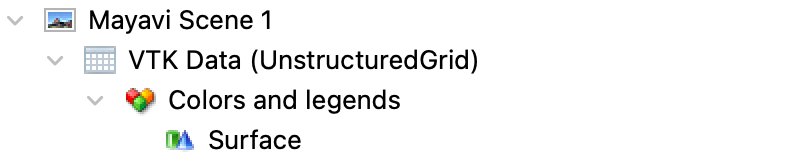

All pipelines are rooted in an engine (an instance of  the Mayavi program), then a scene (a window). Each scene can parent data sources, which in our case may be a TVTK mesh (Traited VTK, see next section) that represents the gravitational waves or a parametric surface representing a black hole. 

Mayavi now recognizes this data, but nothing will be rendered yet. That's is because we haven't told Mayavi how to render it. To do this, we use a visualization module. Mayavi has several visualization modules with varying degrees of customizability, but for this visualization we are mostly focused on the surface module, since we are just trying to displace the surfaces of the data we're looking at. The Mayavi documentation shows how just one data set can be visualized in several ways, as seen in the image below.

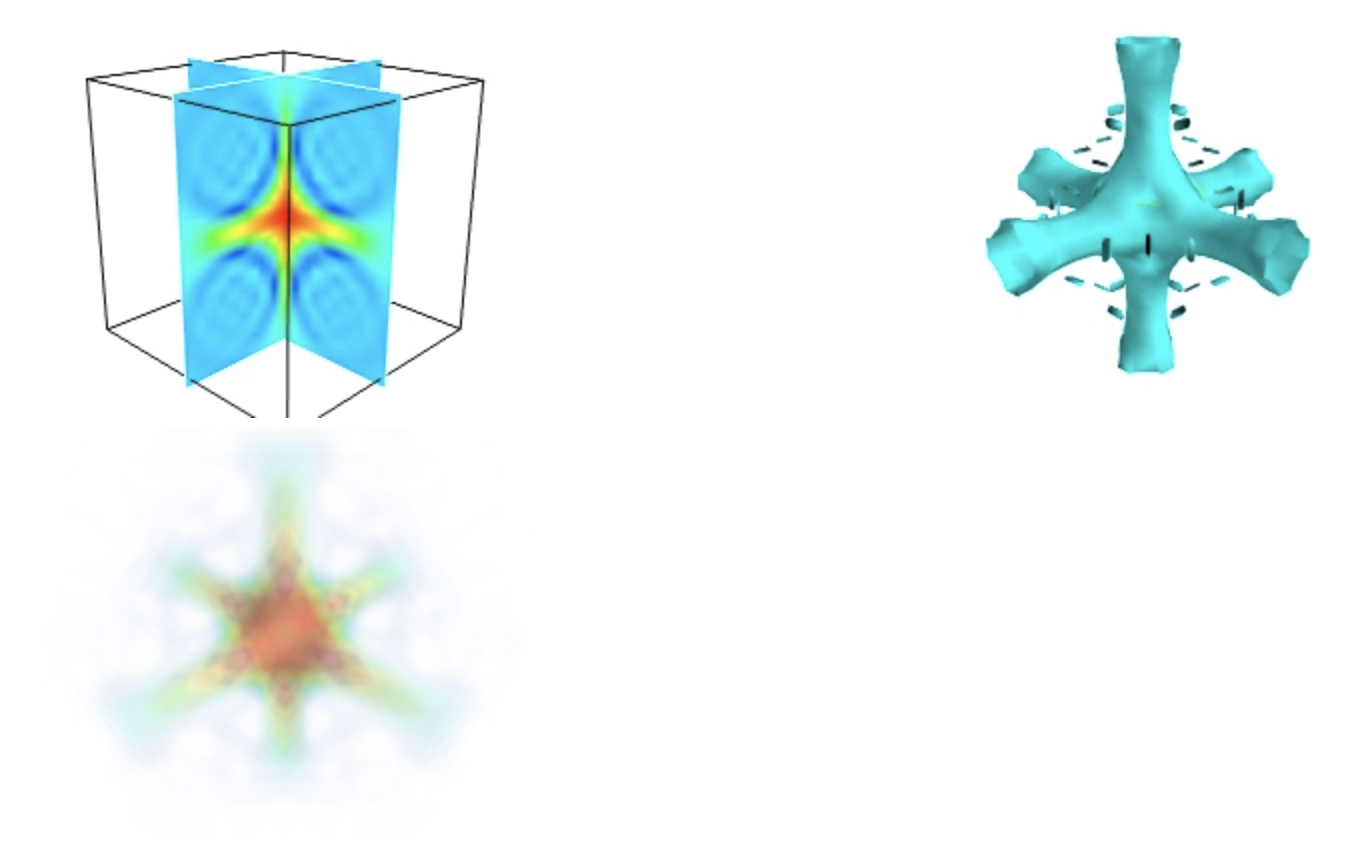

For more reading on the pipeline, visit [this page on the Mayavi documentation](https://docs.enthought.com/mayavi/mayavi/pipeline.html).

You can see the pipeline workflow at work creating a gravitational wave surface:



In [ ]:
# code snippet from mesh generation script - not intended to work in this notebook
from mayavi import mlab
from mayavi.api import Engine

def create_gw(
    engine: Engine,
    grid: Any,
    color: Tuple[float, float, float],
    wireframe: bool = False,
) -> None:
    scene = engine.scenes[0]
    gw = VTKDataSource(data=grid) # Prepares our grid to be passed to Mayavi
    engine.add_source(gw, scene) # Adds a data source to the scene
    s = Surface() # Creates a surface module
    engine.add_filter(s, gw) # Links the surface module to the data source

   # Set the surface module's properties
    s.actor.mapper.scalar_visibility = False
    s.actor.property.color = color


engine = Engine()
engine.start() # Start the engine
mlab.figure(engine=engine, size=(1920,1080)) # Create a new scene (figure) with the engine
create_gw(engine, grid, (0.28, 0.46, 1.0))

<a id='tvtk'></a>

## Step 4.b: Traited VTK (TVTK) and Meshes \[Back to [top](#toc)\]
$$\label{tvtk}$$

Mayavi uses TVTK (Traited VTK) to render all data, even if the input isn't in the form of a TVTK. VTK (Visualization Toolkit) datasets are standard for these kinds of visualizations, and TVTK (as explained in the [TVTK documentation](https://docs.enthought.com/mayavi/tvtk/README.html#introduction)) wraps a VTK object with [traits](https://docs.enthought.com/traits/) that help keep data types consistent. Our gravitational waves are based on a VTK mesh, or an unstructured grid. This is a simple data structure that stores a few different kinds of data:

**Data Points:** Positional data given in the form of cartesian coordinates.

**Connectivity:** This defines a connection drawn between two lines. 

**Point Data:** This can be either scalar or vector data attributed to each data point.

**Cell Data:** This can be either scalar or vector data attributed to each cell (the surface defined by three or more connected data points).

The below image is from the Mayavi documentaion:

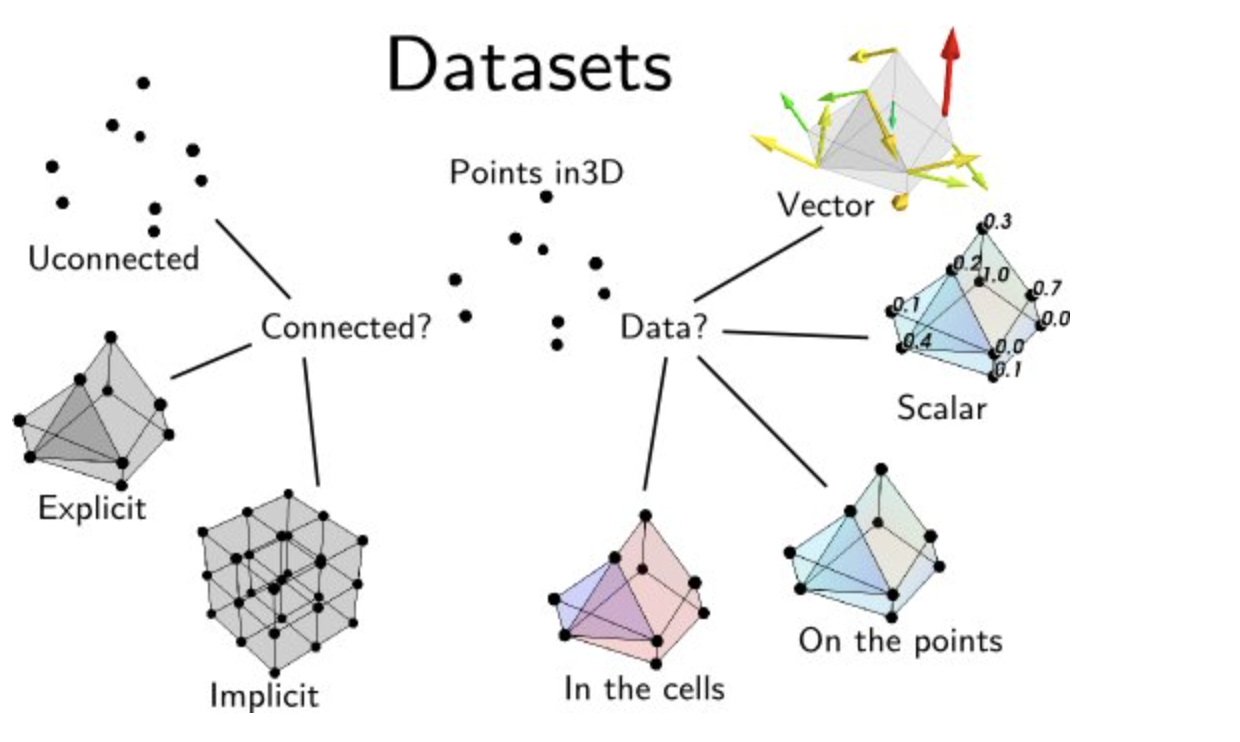

In order to render the gravitational waves, we first initialize a TVTK mesh with a point for each point in a polar grid. We also define a square cell in between every four adjacent points (including diagonality). Note that these points aren't yet assigned positonal data nor scalar data, just connectivity data.

In [ ]:
def initialize_tvtk_grid(num_azi: int, num_radius: int) -> Tuple:
   # Create tvtk objects
   points = tvtk.Points()
   grid = tvtk.UnstructuredGrid()
   strain_array = tvtk.FloatArray(
      name="Strain", number_of_components=1, number_of_tuples=num_azi * num_radius
   )

   # Create cells
   cell_array = tvtk.CellArray()

   # Iterate through the polar grid points
   for j in range(num_radius - 1):
      for i in range(num_azi):
         cell = tvtk.Quad() # Create a 4-point cell
         # Assign the point IDs to the cell
         point_ids = [
               i + j * num_azi,
               (i + 1) % num_azi + j * num_azi,
               (i + 1) % num_azi + (j + 1) * num_azi,
               i + (j + 1) * num_azi,
         ]
         for idx, pid in enumerate(point_ids):
               cell.point_ids.set_id(idx, pid)
         cell_array.insert_next_cell(cell)
   grid.set_cells(tvtk.Quad().cell_type, cell_array)

   return strain_array, grid, points

display_radius = 300
n_rad_pts = 450
num_azi_points = 180

# Theta and radius values for the mesh
radius_values = np.linspace(0, display_radius, n_rad_pts)
azimuth_values = np.linspace(0, 2 * np.pi, n_azi_pts, endpoint=False)

# x and y values for the mesh
rv, az = np.meshgrid(radius_values, azimuth_values, indexing="ij")
x_values = rv * np.cos(az)
y_values = rv * np.sin(az)

After initalizing the grid, we can enter a loop iterating through every time state of the simulation. For each time state, we must loop through every mesh point and assign it a positional value, along with a scalar value (if desired). 

In [ ]:
for time_idx in range(num_time_states):
   # Update the black hole positions
   change_object_position(bh1, bh1_xyz) 
   change_object_position(bh2, bh2_xyz)

   points.reset() # Reset the points
   index = 0
   for rad_idx, radius in enumerate(radius_values):
         # This is a cosmetic factor that makes the strain drop off as we move towards the center
         dropoff_factor = 0.5 + 0.5 * erf((radius - dropoff_radius) / width) 
         for azi_idx, _ in enumerate(azimuth_values):
            x = x_values[rad_idx, azi_idx]
            y = y_values[rad_idx, azi_idx]
            if radius <= omitted_radius_length:
               strain_value = np.nan # Leave a hole in the mesh so you can see the black holes
            else:
               strain_value = strain_to_mesh[rad_idx][azi_idx][time_idx]
            z = strain_value * amplitude_scale_factor * dropoff_factor
            points.insert_next_point(x, y, z) # Assign the point a position
            strain_array.set_tuple1(index, strain_value)
            index += 1

   grid._set_points(points) # Set the points in the grid
   grid._get_point_data().add_array(strain_array) # Add the strain array to the grid
   grid.modified() # This ensures that Mayavi knows the grid has been updated

When we attach the grid data source to a surface (as in the last section) the surface automatically updates when `grid.modified()` is called.

<a id='misc'></a>

## Step 4.c: Miscellaneous Mayavi Functions \[Back to [top](#toc)\]
$$\label{misc}$$
Mayavi provides a wide array of functionality for visualization, here are some of the tools we used (for help learning how to use Mayavi functions in Python by yourself, see Step 4.e).

### Camera Control
Mayavi's camera can be easily maneuvered from the helpful `mlab.view` function. The below is from the [Mayavi documentation](https://docs.enthought.com/mayavi/mayavi/auto/mlab_camera.html#view):

**mayavi.mlab.view**(*azimuth=None, elevation=None, distance=None, focalpoint=None, roll=None, reset_roll=True, figure=None*)

Sets/Gets the view point for the camera:

If called with no arguments this returns the current view of the camera. To understand how this function works imagine the surface of a sphere centered around the visualization. The azimuth argument specifies the angle “phi” on the x-y plane which varies from 0-360 degrees. The elevation argument specifies the angle “theta” from the z axis and varies from 0-180 degrees. The distance argument is the radius of the sphere and the focalpoint, the center of the sphere.

Note that if the elevation is close to zero or 180, then the azimuth angle refers to the amount of rotation of a standard x-y plot with respect to the x-axis. Thus, specifying view(0,0) will give you a typical x-y plot with x varying from left to right and y from bottom to top.

**Keyword arguments:**

**azimuth:**
float, optional. The azimuthal angle (in degrees, 0-360), i.e. the angle subtended by the position vector on a sphere projected on to the x-y plane with the x-axis.

**elevation:**
float, optional. The zenith angle (in degrees, 0-180), i.e. the angle subtended by the position vector and the z-axis.

**distance:**
float or ‘auto’, optional. A positive floating point number representing the distance from the focal point to place the camera. New in Mayavi 3.4.0: if ‘auto’ is passed, the distance is computed to have a best fit of objects in the frame.

**focalpoint:**
array_like or ‘auto’, optional. An array of 3 floating point numbers representing the focal point of the camera. New in Mayavi 3.4.0: if ‘auto’ is passed, the focal point is positioned at the center of all objects in the scene.

**roll:**
float, optional Controls the roll, ie the rotation of the camera around its axis.

**reset_roll:**
boolean, optional. If True, and ‘roll’ is not specified, the roll orientation of the camera is reset.

**figure:**
The Mayavi figure to operate on. If None is passed, the current one is used.

**Returns:**

If no arguments are supplied it returns a tuple of 4 values (azimuth, elevation, distance, focalpoint), representing the current view. Note that these can be used later on to set the view.

If arguments are supplied it returns None.

<a id='movie'></a>

## Step 4.d: Record Frames and Compile an mp4 \[Back to [top](#toc)\]
$$\label{movie}$$
Of course, the renders are of little use if you cannot record them. This is a fairly straightforward process which, when each time state is rendered, captures the render and saves it as a png. After every state is rendered and captured, we use `cv2.VideoWriter` to stitch the png's together into an mp4.

Saving a png for each frame is a simple command with Mayavi's mlab module:

In [ ]:
mlab.savefig(frame_path, magnification=1) # Save the frame

From there, creating a movie is a somewhat tedious (but not difficult) process:

In [ ]:
def convert_to_movie(input_path: str, movie_name: str, fps: int = 24) -> None:
   frames = [f for f in os.listdir(input_path) if f.endswith(".png")]
   frames.sort() # Create a sorted list of all the captured frames
   # Create a movie from the frames
   ref = cv2.imread(os.path.join(input_path, frames[0]))
   height, width, _ = ref.shape
   video = cv2.VideoWriter(
      os.path.join(input_path, f"{movie_name}.mp4"),
      cv2.VideoWriter_fourcc(*"mp4v"),
      fps,
      (width, height),
   )
   for frame in frames:
      f = cv2.imread(os.path.join(input_path, frame))
      video.write(f)
   video.release()

Congratulations! You should now have an mp4 with a render of orbiting black holes and their gravitational waves.

<a id='more'></a>

## Step 4.e: Doing More in Mayavi \[Back to [top](#toc)\]
$$\label{more}$$

Mayavi is a large program with a lot of functionality not covered in this notebook. 

<a id='conclusion'></a>

# Step 5: Conclusion \[Back to [top](#toc)\]
$$\label{conclusion}$$

(overview of what we did)

#### Reference and continued reading:
(through some sources and neat stuff here)

<a id='latex_pdf_output'></a>

# Step 6: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-Psi4_to_mp4.pdf](Tutorial-Start_to_Finish-Psi4_to_mp4.pdf). (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

(quick note, we might not even need this, figured I'd put it in here for now. It will require the necessary tools from nrpy)

In [ ]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-Psi4_to_mp4")

ModuleNotFoundError: No module named 'cmdline_helper'